In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/liverpool-ion-switching/train.csv
/kaggle/input/liverpool-ion-switching/test.csv
/kaggle/input/liverpool-ion-switching/sample_submission.csv


In [2]:
df = pd.read_csv("/kaggle/input/liverpool-ion-switching/train.csv")
df.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [3]:
import gc
import time
import math
from numba import jit
from math import log, floor

import numpy as np
import pandas as pd
from pathlib import Path

import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

import pywt
from statsmodels.robust import mad

import scipy
from scipy import signal
from scipy.signal import butter, deconvolve

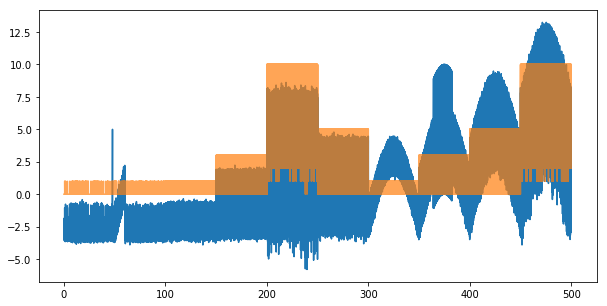

In [4]:
plt.figure(figsize=(10,5))
plt.plot(df.time, df.signal)
plt.plot(df.time, df.open_channels,alpha=0.7)
plt.show()

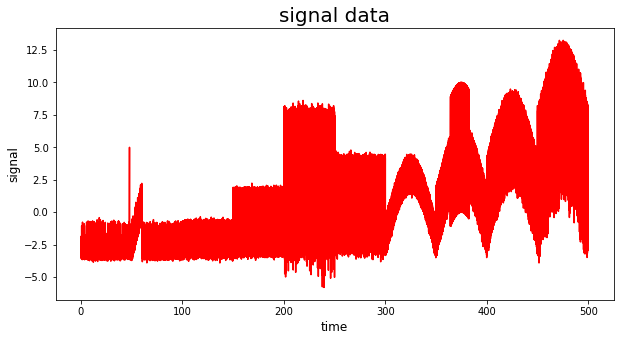

In [5]:
train = pd.read_csv('/kaggle/input/liverpool-ion-switching/train.csv')
test = pd.read_csv('/kaggle/input/liverpool-ion-switching/test.csv')
plt.figure(figsize=(10, 5))
plt.plot(train['time'],train['signal'],color='r')
plt.title('signal data', fontsize=20)
plt.xlabel('time', fontsize=12)
plt.ylabel('signal', fontsize=12)
plt.show()

In [6]:
train.corr()

,time,signal,open_channels
time,1.000000,0.831239,0.569601
signal,0.831239,1.000000,0.801670
open_channels,0.569601,0.801670,1.000000


In [7]:
test.corr()

,time,signal
time,1.000000,-0.421918
signal,-0.421918,1.000000


In [8]:
def add_batching_to_data(df : pd.DataFrame) -> pd.DataFrame :
    batches = df.shape[0] // 500000
    df['batch'] = 0
    for i in range(batches):
        idx = np.arange(i*500000, (i+1)*500000)
        df.loc[idx, 'batch'] = i + 1
    return df

def p5( x : pd.Series) -> pd.Series : return x.quantile(0.05)
def p95(x : pd.Series) -> pd.Series : return x.quantile(0.95)

In [9]:
train = add_batching_to_data(train)

In [10]:
train.groupby('batch')[['signal','open_channels']].agg(['min', 'max', 'median', p5, p95])

signal                                       open_channels             \
          min      max  median        p5        p95           min max median   
batch                                                                          
1     -3.8506   4.9998 -2.7098 -3.125600  -2.208300             0   1      0   
2     -3.9021   2.2236 -2.6476 -3.105600  -0.396395             0   1      0   
3     -3.9107  -0.3525 -1.6101 -2.945900  -1.130700             0   1      1   
4     -3.7073   2.2404 -0.1340 -1.782800   1.255200             0   3      2   
5     -5.7965   8.6131  3.3926  0.281700   6.153400             0  10      7   
6     -3.8174   4.7929  1.9179 -0.502805   3.617700             0   5      4   
7     -3.5033   4.4771  1.6736 -1.483200   3.548400             0   1      1   
8     -3.4952   9.9998  3.2293 -0.272205   5.904000             0   3      2   
9     -3.2033   9.4897  4.9765  1.330100   7.934000             0   5      4   
10    -3.9085  13.2440  6.5999  2.376000  10.273000             1  10      7   

              
      p5 p95  
batch         
1      0   0  
2      0   0  
3      0   1  
4      1   3  
5      5   9  
6      2   5  
7      0   1  
8      1   3  
9      2   5  
10     5   9

In [11]:
train.groupby('open_channels')[['signal','batch']].agg(['min', 'max', 'median', p5, p95])

signal                                       batch             \
                  min      max  median        p5        p95   min max median   
open_channels                                                                  
0             -5.7965   9.9528 -2.6595 -3.109900   1.056245     1   9      2   
1             -5.3438   9.9987 -1.1250 -1.831200   3.449500     1  10      4   
2             -4.6254   9.9998  0.1494 -0.637785   4.728300     4  10      8   
3             -3.1726   9.9998  1.3862  0.572800   5.945100     4  10      6   
4             -2.1492   8.3958  2.5951  1.490690   7.130700     5  10      6   
5             -0.9996   9.4897  3.6542  0.497300   8.248100     5  10      9   
6              0.1303   8.4208  2.5536  1.407600   6.963300     5  10     10   
7              1.3480   9.6833  3.7647  2.640500   8.198300     5  10     10   
8              2.4193  11.1990  4.9867  3.877600   9.439300     5  10      5   
9              3.9629  12.1340  6.1871  5.108295  10.677000     5  10      5   
10             5.3285  13.2440  7.4271  6.332700  11.923000     5  10      5   

                      
              p5 p95  
open_channels         
0              1   7  
1              3   8  
2              4   9  
3              4   9  
4              6   9  
5              5  10  
6              5  10  
7              5  10  
8              5  10  
9              5  10  
10             5  10

In [12]:
train.groupby(['batch','open_channels'])[['signal']].agg(['min', 'max', 'median', p5, p95])

signal                                        
                        min      max    median        p5        p95
batch open_channels                                                
1     0             -3.8506   4.9998  -2.72000 -3.129400  -2.314000
      1             -2.4036  -0.4163  -1.48320 -1.897600  -1.080050
2     0             -3.9021   1.1587  -2.66310 -3.110700  -0.481600
      1             -2.4582   2.2236  -1.36830 -1.860800   1.158500
3     0             -3.9107  -1.4957  -2.73650 -3.143600  -2.328900
      1             -2.7586  -0.3525  -1.50150 -1.910600  -1.095375
4     0             -3.7073  -1.7493  -2.73990 -3.180530  -2.291825
      1             -2.7763  -0.3116  -1.50500 -1.952500  -1.060900
      2             -1.5271   0.9555  -0.27510 -0.722400   0.168180
      3             -0.2341   2.2404   0.95690  0.508700   1.402000
5     0             -5.7965  -5.7481  -5.77230 -5.794080  -5.750520
      1             -5.3438  -3.3162  -4.32820 -4.993020  -3.540260
      2             -4.6254  -1.6356  -2.99355 -3.671925  -2.366200
      3             -3.1726  -0.3517  -1.76550 -2.437550  -1.077950
      4             -2.1492   0.9949  -0.52700 -1.211640   0.157460
      5             -0.9996   2.4400   0.71300  0.031900   1.395900
      6              0.1303   3.7926   1.94030  1.256400   2.623000
      7              1.3480   4.9947   3.17640  2.493600   3.856000
      8              2.4193   6.0338   4.41070  3.736000   5.087900
      9              3.9629   7.1794   5.64270  4.970945   6.320500
      10             5.3285   8.6131   6.87675  6.198770   7.556515
6     0             -3.8174  -1.7285  -2.72505 -3.216825  -2.270525
      1             -2.8902  -0.3566  -1.49810 -1.979200  -1.011755
      2             -1.5576   0.9042  -0.26460 -0.748400   0.218500
      3             -0.2754   2.2316   0.96830  0.488400   1.448400
      4              0.9769   3.4705   2.20380  1.723300   2.684000
      5              2.1698   4.7929   3.43810  2.959300   3.916000
7     0             -3.5033   3.2060   0.82600 -2.353630   2.377400
      1             -2.3241   4.4771   2.01670 -1.116080   3.604900
8     0             -3.4952   9.9528   0.55645 -2.409240   2.459775
      1             -2.8414   9.9987   1.87030 -1.176800   3.691500
      2             -1.2088   9.9998   3.17600  0.044600   4.936000
      3             -1.0893   9.9998   4.44190  1.313465   6.167900
9     0             -3.2033   2.9513   0.55170 -2.501930   2.310580
      1             -2.2494   4.3286   2.07310 -1.186770   3.618530
      2             -1.0989   5.8212   3.30560  0.048500   4.868000
      3              0.1085   7.0330   4.49965  1.315665   6.094300
      4              1.1508   8.3958   5.67385  2.572500   7.327875
      5              2.6939   9.4897   6.91750  3.855780   8.562800
10    1             -3.9085   1.4398  -0.40390 -3.121940   1.125500
      2             -3.4849   2.9519   0.70490 -2.571700   2.317500
      3             -2.5633   4.3780   1.83780 -1.410900   3.463460
      4             -1.7234   6.0027   3.00690 -0.110360   4.726120
      5             -0.4914   7.2001   4.19065  1.064800   5.952750
      6              0.7574   8.4208   5.40020  2.285740   7.186380
      7              1.6189   9.6833   6.65655  3.515700   8.425200
      8              2.9139  11.1990   7.93505  4.752285   9.667600
      9              4.1721  12.1340   9.21400  5.963345  10.911000
      10             5.4508  13.2440  10.46200  7.157100  12.151000

In [13]:
partial = train.iloc[::250, :]
partial.signal = np.round(partial.signal.values, 2)
partial['shifted_signal'] = (partial.signal.values + 10) ** 2
fig = px.scatter(partial, x='signal', y='open_channels', color='open_channels',size='shifted_signal',  title='Signal vs Channels')
fig.show()

In [14]:
fig = make_subplots(rows=5, cols=2,  subplot_titles=[f'Batch no {i+1}' for i in range(10)])
i = 1
for row in range(1, 6):
    for col in range(1, 3):
        data = train[train.batch==i]['open_channels'].value_counts(sort=False).values
        fig.add_trace(go.Bar(x=list(range(11)), y=data), row=row, col=col)       
        i += 1
fig.update_layout(width=800, height=1500, title_text="Target for each batch", showlegend=False)